# **ML Assignment 7**

By 23520011 - Sharaneshwar Punjal

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

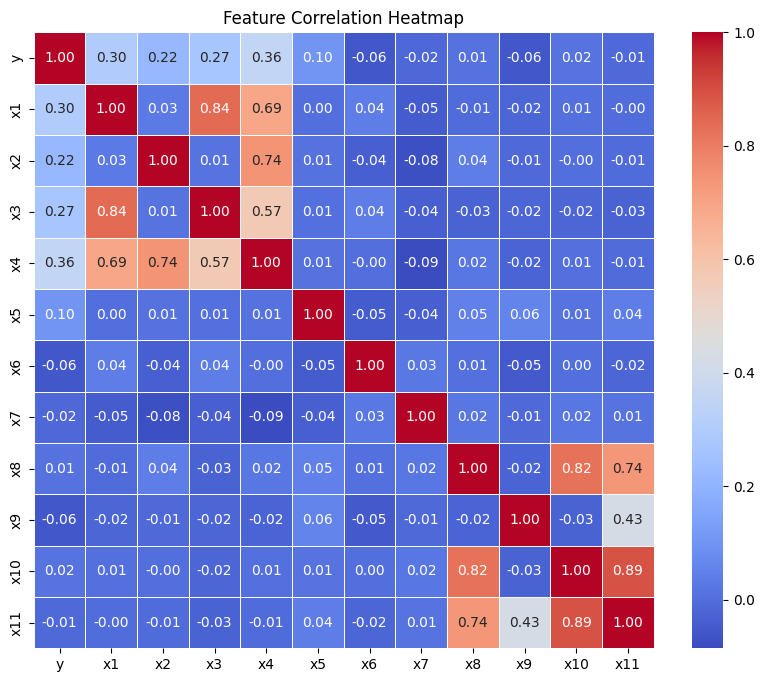

In [3]:
# Load dataset (replace with your actual dataset)
df = pd.read_csv("linear_regression_3.csv")

# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### **Observation about the data:**

1. Target Variable (y) Correlation:
- y has the highest correlation with x4 (0.36), x3 (0.27), and x1 (0.30).
- Other features have weaker correlations with y, meaning they might not significantly impact the target variable.

2. Feature Correlations:
- x1 and x3 have a strong positive correlation (0.84), meaning they may have redundant information.
- x2 and x4 also have a high correlation (0.74).
- x10 and x11 have a very high correlation (0.89), which suggests possible collinearity.
- x8 is highly correlated with x10 (0.82) and x11 (0.74).

3. Low-Correlation Features:
- Features like x5, x6, x7, and x9 have very low correlation with most other features and the target variable.

4.	Conclusion:
- Some features are highly correlated (x1 & x3, x10 & x11), which may lead to multicollinearity issues in regression models.
- Feature selection methods can be used to remove redundancy.

## **Steps taken to fit regression model efficiently**

### Step 1 : Splitting the data using train test split
Here, the data is splitted in 80 & 20%, random state 42 is taken to ensure every time when we give input data with same condition the output will be same i.e consistent result.

In [4]:
target_col = df.columns[0]
feature_cols = df.columns[1:]

# Splitting the data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

### Step 2 : Use of VIF to drop the high VIF features

- Here, initially all the features are included except the target(y)
- The constants/bias is added to ensure that the regression line not passing through origin.
- All features VIF is calculated then one with highest VIF greater than 10 are dropped, iteratively update the features list and perform next iterations until max_vif < 10

In [ ]:
# VIF approach
def optimize_vif(df, target):
    features = df.columns[df.columns != target].tolist()
    y = df[target]
    X = sm.add_constant(df[features])

    # Init R²
    model = sm.OLS(y, X).fit()
    initial_r2 = model.rsquared
    print(f"Initial R²: {initial_r2:.4f}\n")

    step = 0
    while True:
        X = sm.add_constant(df[features])  # adds column of 1's as a bias
        vif_data = pd.DataFrame()
        vif_data["Feature"] = features
        vif_data["VIF"] = [variance_inflation_factor(X.values, i + 1) for i in range(len(features))]

        print(f"Step {step}:\n", vif_data, "\n")

        max_vif = vif_data["VIF"].max()
        if max_vif < 10:
            break

        # Dropping feature with highest VIF
        drop_feature = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
        features.remove(drop_feature)

        # new R²
        X_new = sm.add_constant(df[features])
        model = sm.OLS(y, X_new).fit()
        new_r2 = model.rsquared

        print(f"Step {step}: Dropped {drop_feature}, New R²: {new_r2:.4f}\n")
        step += 1

    return df[[target] + features]

### Step 3: Drop the features from test data same as train data

As the features dropped from training set, no use of keeping those in testing set hence removing from testing set also.

In [6]:
# Apply VIF method
train_data = optimize_vif(train_data, target_col)

# Apply the same for test data
test_data = test_data[train_data.columns]

Initial R²: 0.1918

Step 0:
    Feature           VIF
0       x1  39860.858417
1       x2  43631.560482
2       x3      3.409059
3       x4  86813.889417
4       x5      1.015734
5       x6      1.013290
6       x7      1.013122
7       x8      3.267030
8       x9    288.902351
9      x10   1211.166567
10     x11   1470.484459 

Step 0: Dropped x4, New R²: 0.1913

Step 1:
   Feature          VIF
0      x1     3.415511
1      x2     1.011655
2      x3     3.398846
3      x5     1.014815
4      x6     1.013079
5      x7     1.012949
6      x8     3.265263
7      x9   288.248243
8     x10  1208.225779
9     x11  1466.959833 

Step 1: Dropped x11, New R²: 0.1913

Step 2:
   Feature       VIF
0      x1  3.412918
1      x2  1.010569
2      x3  3.395295
3      x5  1.013640
4      x6  1.011354
5      x7  1.012949
6      x8  3.265203
7      x9  1.006317
8     x10  3.248256 



### Step 4: Train the linear regression model after selecting the features

Fitting the linear model to see improvement in our r2 or not.

In [8]:
# Train linear regression model
X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]

model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

# Compute R² for training data
r2_train = r2_score(y_train, y_train_pred)

# test data
X_test = test_data.drop(columns=[target_col])
y_test = test_data[target_col]

# R² for test data
y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Final Training R²: {r2_train:.4f}")
print(f"Final Testing R²: {r2_test:.4f}")
print("\nFinal Selected Features:", X_train.columns.tolist())

Final Training R²: 0.1913
Final Testing R²: -0.0577

Final Selected Features: ['x1', 'x2', 'x3', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']


### Step 5: Identify the influential points using cook’s distance

Here, we are removing this Influential points because they can distort the regression line, leading to misleading predictions.

In [9]:
# Function to identify influential points using Cook’s Distance
def identify_influential_points(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]
    leverage = influence.hat_matrix_diag

    # Threshold calculated here
    cooks_threshold = 4 / len(df)
    leverage_threshold = 3 * (X.shape[1] / len(df))

    # influential points
    influential_mask = (cooks_d < cooks_threshold) & (leverage < leverage_threshold)
    return df[influential_mask]


train_data_cleaned = identify_influential_points(train_data, target_col)

X_train = train_data_cleaned.drop(columns=[target_col])
y_train = train_data_cleaned[target_col]

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

r2_train = r2_score(y_train, y_train_pred)

print(f"After Removing Influential Points - Training R²: {r2_train:.4f}")

test_data_cleaned = identify_influential_points(test_data, target_col)

# R2 after removing influential points (Testing)
X_test = test_data_cleaned.drop(columns=[target_col])
y_test = test_data_cleaned[target_col]

y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"After Removing Influential Points - Testing R²: {r2_test:.4f}")

After Removing Influential Points - Training R²: 0.8275
After Removing Influential Points - Testing R²: 0.8390
